In [1]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
import lightgbm as lgb
import numpy as np, pandas as pd
from  datetime import datetime, timedelta
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import os, gc, time
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/basedf-m5/BASE_df (1).pkl
/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv
/kaggle/input/m5-forecasting-accuracy/sample_submission.csv
/kaggle/input/m5-forecasting-accuracy/calendar.csv
/kaggle/input/m5-forecasting-accuracy/sell_prices.csv
/kaggle/input/m5-forecasting-accuracy/sales_train_evaluation.csv
/kaggle/input/m5-fe-grids/price_grid1 (1).pkl
/kaggle/input/m5-fe-grids/lag_grid1 (1).pkl
/kaggle/input/m5-fe-grids/time_grid (1).pkl
/kaggle/input/m5-fe-grids/price_grid2 (1).pkl


In [2]:
from typing import List

def optimize_floats(df: pd.DataFrame) -> pd.DataFrame:
    floats = df.select_dtypes(include=['float64']).columns.tolist()
    df[floats] = df[floats].apply(pd.to_numeric, downcast='float')
    return df

def optimize_ints(df: pd.DataFrame) -> pd.DataFrame:
    ints = df.select_dtypes(include=['int64']).columns.tolist()
    df[ints] = df[ints].apply(pd.to_numeric, downcast='integer')
    return df

def optimize_objects(df: pd.DataFrame, datetime_features: List[str]) -> pd.DataFrame:
    for col in df.select_dtypes(include=['object']):
        if col not in datetime_features:
            num_unique_values = len(df[col].unique())
            num_total_values = len(df[col])
            if float(num_unique_values) / num_total_values < 0.5:
                df[col] = df[col].astype('category')
        else:
            df[col] = pd.to_datetime(df[col])
    return df

def optimize(df: pd.DataFrame, datetime_features: List[str] = [], verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2
    df = optimize_floats(optimize_ints(optimize_objects(df, datetime_features)))
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:3.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
#PATHS for Features
ORIGINAL = '../input/m5-forecasting-accuracy/'
BASE     = '/kaggle/input/basedf-m5/BASE_df (1).pkl'
PRICE1   = '/kaggle/input/m5-fe-grids/price_grid1 (1).pkl'
TIME     = '/kaggle/input/m5-fe-grids/time_grid (1).pkl'
LAGS     = '/kaggle/input/m5-fe-grids/lag_grid1 (1).pkl'
PRICE2   = '/kaggle/input/m5-fe-grids/price_grid2 (1).pkl'
SUB = ORIGINAL+'sample_submission.csv'

target = 'demand'
train_boundary = pd.datetime(2015, 2, 27)
valid_boundary = pd.datetime(2016, 2, 27)
test_boundary = pd.datetime(2016, 3, 27)
lgbm_epochs = 50
ESR = 150
VE = 10 
SEED = 657

In [4]:
def get_df():
    print('Loading from Pickle...')
    df = pd.concat([pd.read_pickle(BASE),
                    pd.read_pickle(PRICE1).iloc[:,5:],
                    pd.read_pickle(TIME).iloc[:,2:],
                    pd.read_pickle(LAGS).iloc[:,2:],
                    pd.read_pickle(PRICE2).iloc[:,2:]],
                    axis=1)
    return df

In [5]:
def mod_df(df): 
    del df['Elapsed']
    df.sell_price.replace(np.nan, 0, inplace=True)
    df.amount.replace(np.nan, 0, inplace=True)
    df = optimize(df,['date'])
    gc.collect()
    return df

In [6]:
%%time
df = get_df()

Loading from Pickle...
CPU times: user 18.1 s, sys: 38.3 s, total: 56.4 s
Wall time: 57 s


In [7]:
%%time
df = mod_df(df)

Mem. usage decreased to 4838.57 Mb (35.2% reduction)
CPU times: user 16.8 s, sys: 12 s, total: 28.8 s
Wall time: 28.9 s


In [8]:
# # Memo all columns
# ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'demand',
#        'date', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
#        'snap_CA', 'snap_TX', 'snap_WI', 'wholesale_inventory',
#        'wholesale_sales', 'retai_t_f_sales', 'urban_cpi', 'cpi', 'unemp_rate',
#        'ppi', 'gdp', 'sell_price', 'amount', 'outlier', 'log_price',
#        'log_amount', 'box_amount', 'log_tran_demand', 'rolling_price_std_t5',
#        'rolling_price_mean_t5', 'rolling_price_std_t7',
#        'rolling_price_mean_t7', 'rolling_price_std_t14',
#        'rolling_price_mean_t14', 'rolling_price_std_t28',
#        'rolling_price_mean_t28', 'weekday_cos', 'weekday_sin', 'day_month_cos',
#        'day_month_sin', 'month_year_cos', 'month_year_sin', 'day_year_cos',
#        'day_year_sin', 'Year', 'Month', 'Week', 'Day', 'Dayofweek',
#        'Dayofyear', 'Is_month_end', 'Is_month_start', 'Is_quarter_end',
#        'Is_quarter_start', 'Is_year_end', 'Is_year_start', 'lag_5', 'lag_7',
#        'lag_14', 'lag_28', 'rmean_5_5', 'rmean_7_5', 'rmean_14_5',
#        'rmean_28_5', 'rmean_5_7', 'rmean_7_7', 'rmean_14_7', 'rmean_28_7',
#        'rmean_5_14', 'rmean_7_14', 'rmean_14_14', 'rmean_28_14', 'theta',
#        'amplitude', 'freq', 'sell_price_rel_diff', 'growing_price',
#        'sell_price_roll_sd7', 'sell_price_cumrel', 'shift_price_t1',
#        'price_change_t1', 'rolling_price_max_t365', 'price_max', 'price_norm',
#        'price_nunique', 'item_nunique', 'price_momentum']

In [9]:
exclude_cols = ['id', 'item_id', 'demand',
       'date','event_type_1','event_type_2',
       'wholesale_inventory',
       'wholesale_sales', 'retai_t_f_sales', 'urban_cpi', 'cpi', 'unemp_rate',
       'ppi', 'gdp', 'sell_price', 'amount', 'outlier', 'log_price',
       'log_amount', 'box_amount','day_month_cos',
       'day_month_sin', 'month_year_cos', 'month_year_sin', 'day_year_cos',
       'day_year_sin', 'Year', 'Month', 'Week', 'Is_month_end', 'Is_month_start', 'Is_quarter_end',
       'Is_quarter_start', 'Is_year_end', 'Is_year_start', 'sell_price_rel_diff', 'growing_price','sell_price_cumrel', 'shift_price_t1',
       'price_change_t1',
       'price_nunique', 'item_nunique', 'price_momentum']

features = [col for col in df.columns if col not in exclude_cols]

def split_data(df, valid_boundary=valid_boundary, test_boundary=test_boundary, features=features, random=False):
    
    print('Creating train-valid-test splits.')
    index = df['date']
    
    xtest = df.loc[index > test_boundary]
    ytest = xtest[target]  
    gc.collect()
    
    if random:
        xtrain, xvalid, ytrain, yvalid = train_test_split(df, df[target], test_size=0.25, random_state=SEED)
        del df
        gc.collect()
    else:
        xtrain = df.loc[(index <= valid_boundary) & (index > train_boundary)]
        ytrain = xtrain[target]
        gc.collect()
    
        xvalid = df.loc[(index > valid_boundary) & (index <= test_boundary)]
        yvalid = xvalid[target]
        del df
        gc.collect()
    
    return xtrain, ytrain, xvalid, yvalid, xtest, ytest

In [10]:
penalty = 1.15 
# Custom loss which gives [1.15] times more penalty when the true targets are more than predictions as compared to less

# Objective function (fobj)
def custom_asymmetric_train(y_pred, y_true):
    y_true = y_true.get_label()
    residual = (y_true - y_pred).astype("float")
    grad = np.where(residual < 0, -2 * residual, -2 * residual * penalty)
    hess = np.where(residual < 0, 2, 2 * penalty)
    return grad, hess

# Evaluation metric (feval)
def custom_asymmetric_valid(y_pred, y_true):
    y_true = y_true.get_label()
    residual = (y_true - y_pred).astype("float")
    loss = np.where(residual < 0, (residual ** 2) , (residual ** 2) * penalty) 
    return "custom_asymmetric_eval", np.mean(loss), False

In [11]:

def lgbmodel(df, features=features):
    start = time.time()
    xtrain, ytrain, xvalid, yvalid, xtest, ytest = split_data(df)
    end = time.time()
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    print("Time elapsed {:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),int(seconds)))
    del df
    gc.collect()
    
    lgb_train = lgb.Dataset(xtrain[features], ytrain)
    lgb_valid = lgb.Dataset(xvalid[features], yvalid, reference=lgb_train)
    
    del xtrain, ytrain
    gc.collect()
    
    params = {
                'boosting_type': 'gbdt',
                'objective': 'tweedie',
                'tweedie_variance_power': 1.1,
                'metric': 'custom',
#                 'subsample': 0.5,
#                 'subsample_freq': 1,
                'learning_rate': 0.075,
                'num_leaves': 2**11-1,
                'min_data_in_leaf': 2**12-1,
#                 'feature_fraction': 0.5,
                'max_bin': 100,
#                 'boost_from_average': False,
                'verbose': -1,
                'seed': SEED,
            }

    print('Starting training process...')
    start = time.time()
    gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=lgbm_epochs,
                    early_stopping_rounds = ESR,
                    valid_sets=[lgb_train, lgb_valid],
                    verbose_eval=VE,
                    fobj=custom_asymmetric_train,
                    feval=custom_asymmetric_valid)
    end = time.time()
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    print("Time elapsed {:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),int(seconds)))
    
    print('Starting prediction process...')
    start = time.time()
    val_pred = gbm.predict(xvalid[features])
    y_pred = gbm.predict(xtest[features])
    end = time.time()
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    print("Time elapsed {:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),int(seconds)))
    
    print('Done...')
    xvalid['demand'] = val_pred
    xtest['demand'] = y_pred
    
    xvalid = xvalid[['id', 'date', 'demand']]
    xtest = xtest[['id', 'date', 'demand']]
    
    gc.collect()
    
    return xvalid, xtest, gbm

In [12]:
gc.collect()

20

In [13]:
%%time
xvalid, xtest, gbm = lgbmodel(df)

Creating train-valid-test splits.
Time elapsed 00:00:04.00
Starting training process...
Training until validation scores don't improve for 150 rounds
[10]	training's custom_asymmetric_eval: 5.65739	valid_1's custom_asymmetric_eval: 5.7309
[20]	training's custom_asymmetric_eval: 3.10026	valid_1's custom_asymmetric_eval: 2.96976
[30]	training's custom_asymmetric_eval: 2.4906	valid_1's custom_asymmetric_eval: 2.3226
[40]	training's custom_asymmetric_eval: 2.30738	valid_1's custom_asymmetric_eval: 2.14673
[50]	training's custom_asymmetric_eval: 2.2433	valid_1's custom_asymmetric_eval: 2.09145
Did not meet early stopping. Best iteration is:
[50]	training's custom_asymmetric_eval: 2.2433	valid_1's custom_asymmetric_eval: 2.09145
Time elapsed 00:07:15.00
Starting prediction process...
Time elapsed 00:00:12.00
Done...
CPU times: user 27min 55s, sys: 24.8 s, total: 28min 20s
Wall time: 7min 33s


In [14]:
def render_plot_importance(gbm, importance_type, max_features=50, ignore_zero=True, precision=3):
    print('Plot Feature Importance...')
    ax = lgb.plot_importance(gbm, importance_type=importance_type,
                             max_num_features=max_features,
                             ignore_zero=ignore_zero, figsize=(12, 8),
                             precision=precision)
    ax.grid(False)
    plt.title("LightGBM - Feature Importance", fontsize=15)
    plt.show()

Plot Feature Importance...


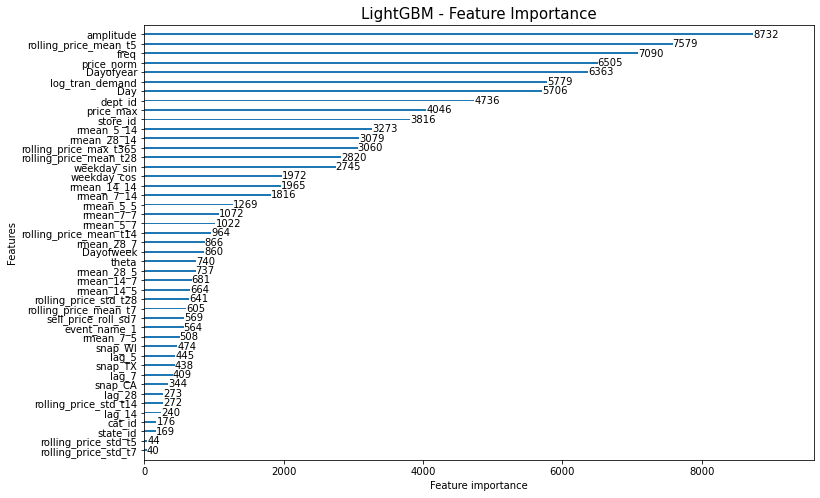

In [15]:
render_plot_importance(gbm, importance_type='split')

In [16]:
def get_predictions(xtest):
    submission = pd.read_csv(SUB)
    predictions = xtest.copy()
    predictions['demand'] = predictions['demand'].clip(0)
    predictions = pd.pivot(predictions, index = 'id', columns = 'date', values = 'demand').reset_index()
    predictions.columns = ['id'] + ['F' + str(i + 1) for i in range(28)]

    evaluation_rows = [row for row in submission['id'] if 'evaluation' in row] 
    evaluation = submission[submission['id'].isin(evaluation_rows)]
    
    submission = submission.assign(id=submission.id.str.replace("_validation", ""))
    validation = submission[['id']].merge(predictions, on = 'id')
    final = pd.concat([validation, evaluation])
    final.to_csv('submission.csv', index = False)
    del submission, xtest, validation, evaluation, final, predictions
    gc.collect

In [17]:
%%time
get_predictions(xtest)

CPU times: user 3.55 s, sys: 36.2 ms, total: 3.58 s
Wall time: 3.64 s


In [18]:
# # Add shifted holiday features
#     for shift in [1, 2, 3, 4, 5]:
#         demand_df['holiday_nl_min_{}'.format(
#             shift)] = demand_df['holiday_nl'].shift(-shift).fillna(value=0).astype('int8')
#         demand_df['holiday_nl_plus_{}'.format(
#             shift)] = demand_df['holiday_nl'].shift(shift).fillna(value=0).astype('int8')
#         demand_df['holiday_be_min_{}'.format(
#             shift)] = demand_df['holiday_be'].shift(-shift).fillna(value=0).astype('int8')
#         demand_df['holiday_be_plus_{}'.format(
#             shift)] = demand_df['holiday_be'].shift(shift).fillna(value=0).astype('int8')

#     # Generate Aggregation Features
#     print('[+] Generating all-time product aggregation features ...')

#     num_aggregations = {
#         'actual_raw': ['max', 'mean', 'median', 'sum', 'std']}

#     full_agg_df = demand_df.groupby('product_id').agg(num_aggregations)
#     full_agg_df.columns = ["_".join(agg_feature) for agg_feature in full_agg_df.columns.ravel()]
#     full_agg_df.reset_index(drop=False, inplace=True)

#     print('[+] Generating monthly product aggregation features ...')
#     month_agg_df = demand_df.groupby(['product_id', 'month']).agg(num_aggregations)
#     month_agg_df.columns = ["_month_".join(agg_feature)
#                             for agg_feature in month_agg_df.columns.ravel()]
#     month_agg_df.reset_index(drop=False, inplace=True)

#     print('[+] Generating weekly product aggregation features ...')
#     week_agg_df = demand_df.groupby(['product_id', 'weekofyear']).agg(num_aggregations)
#     week_agg_df.columns = ["_week_".join(agg_feature)
#                            for agg_feature in week_agg_df.columns.ravel()]
#     week_agg_df.reset_index(drop=False, inplace=True)

#     print('[+] Generating monthly product_type aggregation features ...')
#     pt_month_agg_df = demand_df.groupby(['product_type_id', 'month']).agg(num_aggregations)
#     pt_month_agg_df.columns = ["_pt_month_".join(agg_feature)
#                                for agg_feature in pt_month_agg_df.columns.ravel()]
#     pt_month_agg_df.reset_index(drop=False, inplace=True)

In [19]:
# # Define function
# def target_encoder(df, column, target, index=None, method='mean'):
#     """
#     Target-based encoding is numerization of a categorical variables via the target variable. Main purpose is to deal
#     with high cardinality categorical features without exploding dimensionality. This replaces the categorical variable
#     with just one new numerical variable. Each category or level of the categorical variable is represented by a
#     summary statistic of the target for that level.

#     Args:
#         df (pandas df): Pandas DataFrame containing the categorical column and target.
#         column (str): Categorical variable column to be encoded.
#         target (str): Target on which to encode.
#         index (arr): Can be supplied to use targets only from the train index. Avoids data leakage from the test fold
#         method (str): Summary statistic of the target. Mean, median or std. deviation.

#     Returns:
#         arr: Encoded categorical column.

#     """

#     index = df.index if index is None else index # Encode the entire input df if no specific indices is supplied

#     if method == 'mean':
#         encoded_column = df[column].map(df.iloc[index].groupby(column)[target].mean())
#     elif method == 'median':
#         encoded_column = df[column].map(df.iloc[index].groupby(column)[target].median())
#     elif method == 'std':
#         encoded_column = df[column].map(df.iloc[index].groupby(column)[target].std())
#     else:
#         raise ValueError("Incorrect method supplied: '{}'. Must be one of 'mean', 'median', 'std'".format(method))

#     return encoded_column

In [20]:
# # Encode entire column of df (without train/test split)
# df['product_id_encoded_mean'] = target_encoder(df, column='product_id', target='target', method='mean')
# df

# # Encode entire column of df (without train/test split)
# df['product_type_id_encoded_std'] = target_encoder(df, column='product_type_id', target='target', method='std')
# df

# # Encode only on train indices of column of df to avoid data leakage in folds
# # Note that the value based on the train indices is automatically mapped to the test indices
# df['product_id_encoded_median_train'] = target_encoder(df, column='product_id', target='target', index=[0, 1, 2, 3, 4, 5], method='median')
# df

In [21]:
# class timefold(object):
#     """
#     Cross-validation methods for timeseries data.
#     Available methods
#         * nested
#             Generates train-test pair indices with a growing training window.
#             Example (folds=3):
#             TRAIN: [0 1 2] TEST: [3 4 5]
#             TRAIN: [0 1 2 3 4 5] TEST: [6 7 8]
#             TRAIN: [0 1 2s 3 4 5 6 7] TEST: [8 9]
#         * window
#             Generates train-test pair indices with a moving window.
#             Example (folds=3):
#             TRAIN: [0 1 2] TEST: [3 4 5]
#             TRAIN: [3 4 5] TEST: [6 7 8]
#             TRAIN: [6 7] TEST: [8 9]
#         * step
#             Generates one step ahead train-test pair indices with specified testing size.
#             Fold argument is ignored. The maximum possible number of folds is generated based on
#             the number of samples and specified testing window size.
#             Example (test_size=1):
#             TRAIN: [0] TEST: [1]
#             TRAIN: [0 1] TEST: [2]
#             TRAIN: [0 1 2] TEST: [3]
#             TRAIN: [0 1 2 3] TEST: [4]
#             TRAIN: [0 1 2 3 4] TEST: [5]
#             TRAIN: [0 1 2 3 4 5] TEST: [6]
#             TRAIN: [0 1 2 3 4 5 6] TEST: [7]
#             TRAIN: [0 1 2 3 4 5 6 7] TEST: [8]
#             TRAIN: [0 1 2 3 4 5 6 7 8] TEST: [9]
#         * shrink
#             Generates train-test pair indices with a shrinking training window and constant testing window.
#             Example (folds=3):
#             TRAIN: [0 1 2 3 4 5 6 7] TEST: [8 9]
#             TRAIN: [3 4 5 6 7] TEST: [8 9]
#             TRAIN: [6 7] TEST: [8 9]
#         * stratified
#             Generates stratified train-test pair indices where a ratio is preserved per fold.
#             To be implemented
#     """

#     def __init__(self, folds=10, method='nested', min_train_size=1, min_test_size=1, step_size=1):
#         self.folds = folds
#         self.method = method
#         self.min_train_size = min_train_size
#         self.min_test_size = min_test_size
#         self.step_size = step_size

#     def split(self, X):
#         """
#         Split data into train-test pairs based on specified cross-validation method.
#         """
#         folds = self.folds
#         method = self.method
#         min_train_size = self.min_train_size
#         min_test_size = self.min_test_size
#         step_size = self.step_size

#         X_obs = X.shape[0]
#         indices = np.arange(X_obs)

#         if folds >= X_obs:
#             raise ValueError(
#                 ("The number of folds {0} must be smaller than the number of observations {1}".format(folds, X_obs)))

#         folds += 1
#         fold_indices = np.array_split(indices, folds, axis=0)
#         fold_sizes = [len(fold) for fold in fold_indices][:-1]
#         train_starts = [fold[0] for fold in fold_indices][:-1]
#         train_ends = [fold[0] for fold in fold_indices][1:]

#         if method == 'nested':
#             for end, size in zip(train_ends, fold_sizes):
#                 yield(indices[:end], indices[end:end + size])

#         elif method == 'window':
#             for start, end, size in zip(train_starts, train_ends, fold_sizes):
#                 yield(indices[start:end], indices[end:end + size])

#         elif method == 'step':
#             steps = np.arange(min_train_size, indices[-1], step_size)
#             for step in steps:
#                 yield(indices[:step], indices[step:step + min_test_size])


#         elif method == 'shrink':
#             for start, size in zip(train_starts, fold_sizes):
#                 yield(indices[start:train_ends[-1]], indices[-fold_sizes[-1]:])

#         elif method == 'stratified':
#             pass

#         else:
#             raise ValueError("Unknown method supplied '{0}'. Method must be one of: 'nested', 'window', 'step', "
#                              "'stratified'".format(method))